# 6.6 Sourcing & Analysing Time-Series Data - Zillow Real Estate

### This script contains the following:

#### 1. Importing libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing Zillow Real Estate Data

### 1. Importing libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight') # Styling option for how plots will appear

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'MLTcF2smqn-sB4VAtWst'

In [3]:
# Import the Zillow Real Estate Data "Home values" variable.

data = quandl.get_table('ZILLOW/DATA')

In [4]:
data.head()

,indicator_id,region_id,date,value
None,,,,
0,ZSFH,99999,2024-04-30,471998.338021
1,ZSFH,99999,2024-03-31,470671.863494
2,ZSFH,99999,2024-02-29,471144.364833
3,ZSFH,99999,2024-01-31,474834.034632
4,ZSFH,99999,2023-12-31,478670.136789


In [5]:
data.tail()

,indicator_id,region_id,date,value
None,,,,
9995,ZSFH,99959,2009-06-30,246438.351632
9996,ZSFH,99959,2009-05-31,248906.600421
9997,ZSFH,99959,2009-04-30,251671.631128
9998,ZSFH,99959,2009-03-31,254802.124210
9999,ZSFH,99959,2009-02-28,257771.000546


In [6]:
data['indicator_id'].value_counts(dropna = False)

indicator_id
ZSFH    10000
Name: count, dtype: int64

### 2. Subsetting, wrangling, and cleaning time-series data

In [7]:
# Drop unnecessary columns

data = data.drop(columns=['indicator_id','region_id'])

In [8]:
data.head()

,date,value
None,,
0,2024-04-30,471998.338021
1,2024-03-31,470671.863494
2,2024-02-29,471144.364833
3,2024-01-31,474834.034632
4,2023-12-31,478670.136789


In [9]:
# Check "date" variable

data['date'].value_counts(dropna = False)

date
2015-06-30    40
2014-12-31    40
2016-05-31    40
2016-04-30    40
2016-03-31    40
              ..
1997-03-31     7
1997-04-30     7
1997-06-30     7
1996-01-31     7
2024-05-31     1
Name: count, Length: 341, dtype: int64

In [10]:
# Covert "date" into datetime format

data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')

In [11]:
# Set "date" as the dataset's index

data = data.set_index('date')

In [12]:
data.head()

,value
date,
2024-04-30,471998.338021
2024-03-31,470671.863494
2024-02-29,471144.364833
2024-01-31,474834.034632
2023-12-31,478670.136789


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10000 entries, 2024-04-30 to 2009-02-28
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   10000 non-null  float64
dtypes: float64(1)
memory usage: 156.2 KB


In [30]:
# Check for missing values

data.isnull().sum() 

# No missing values!

value    0
dtype: int64

In [28]:
# Check for duplicates

dups = data.duplicated()
dups.sum()

32

In [31]:
# Create a subset of data prior to 2021

data_sub = data[data.index < '2021-01-01']

In [32]:
data_sub.shape

(8557, 1)

In [34]:
# Resample data to monthly frequency to remove duplicates

data_monthly = data_sub.resample('M').mean()

In [35]:
data_monthly.head()

,value
date,
1996-01-31,144105.857143
1996-02-29,144639.571429
1996-03-31,144922.000000
1996-04-30,145506.714286
1996-05-31,146361.571429


In [37]:
# Check for new duplicates

dups = data_monthly.duplicated()
dups.sum()

# No dups!

0

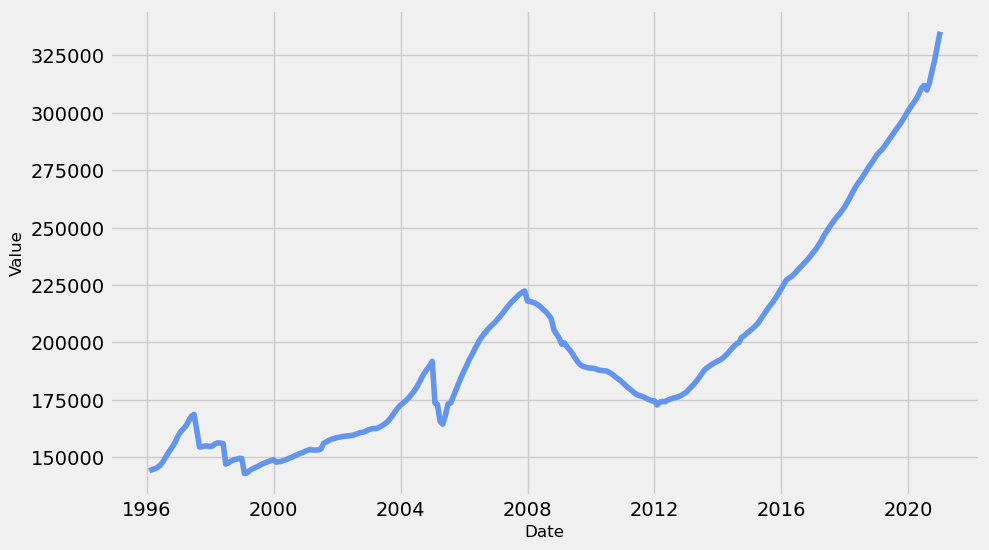

In [38]:
# Plot the new dataset

plt.figure(figsize = (10,6))
plt.plot(data_monthly, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Value', size = 12)
plt.show()

### 3. Time-series analysis: decomposition

In [42]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_monthly, model='additive')

In [40]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

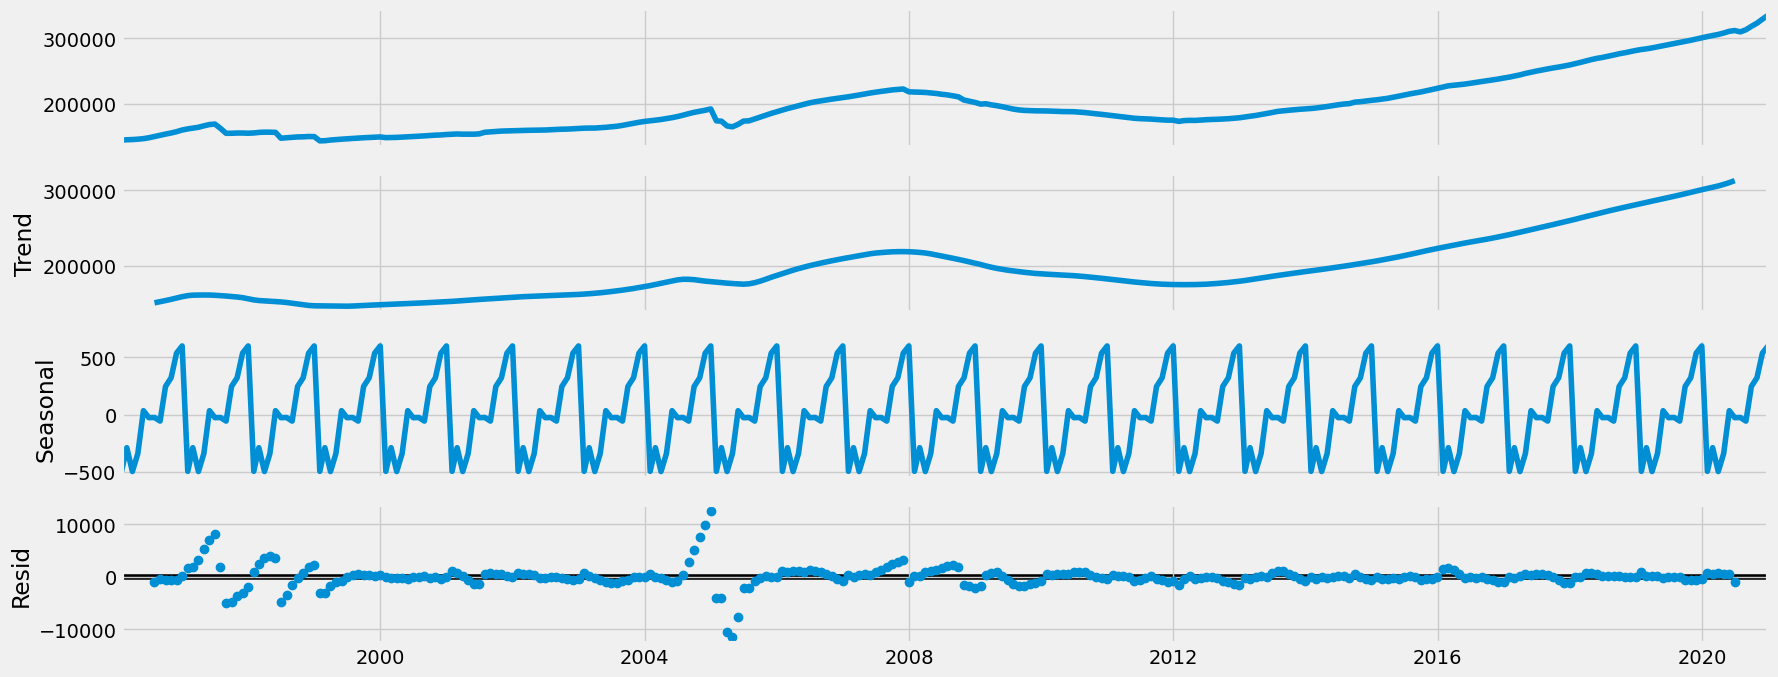

In [43]:
# Plot the separate components

decomposition.plot()
plt.show()

### The level and the trend appear to be quite similar, but not exactly the same. From the trend component, we can observe that property values in the US were slowly but constantly rising from the start of the period - except for a drop around 2005 and a second one in 2012. After 2012, there is a noticeable upward trend, indicating that property values have been increasing steadily up to 2020.
### The seasonal fluctuations indicate a recurring pattern of increases and decreases within each year, suggesting a yearly cycle in property values. This could be due to seasonal demand variations in the US real estate market.
### The residuals seem to be centered around zero with some variations, suggesting that the model fits the data reasonably well, though there are some outliers and irregular variations that are not captured by the trend or seasonal components.

### 4. Testing for stationarity

In [44]:
# Run Dickey-Fuller test for stationarity 

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_monthly['value'])

Dickey-Fuller Stationarity test:
Test Statistic                   2.505152
p-value                          0.999051
Number of Lags Used              2.000000
Number of Observations Used    297.000000
Critical Value (1%)             -3.452561
Critical Value (5%)             -2.871321
Critical Value (10%)            -2.571982
dtype: float64


### Critical Value (5%) = -2.871321. This is much smaller than the test statistic, which is 2.505152, which means that we can’t reject the null hypothesis. Hence there is a unit root in the data, and the data is non-stationary.

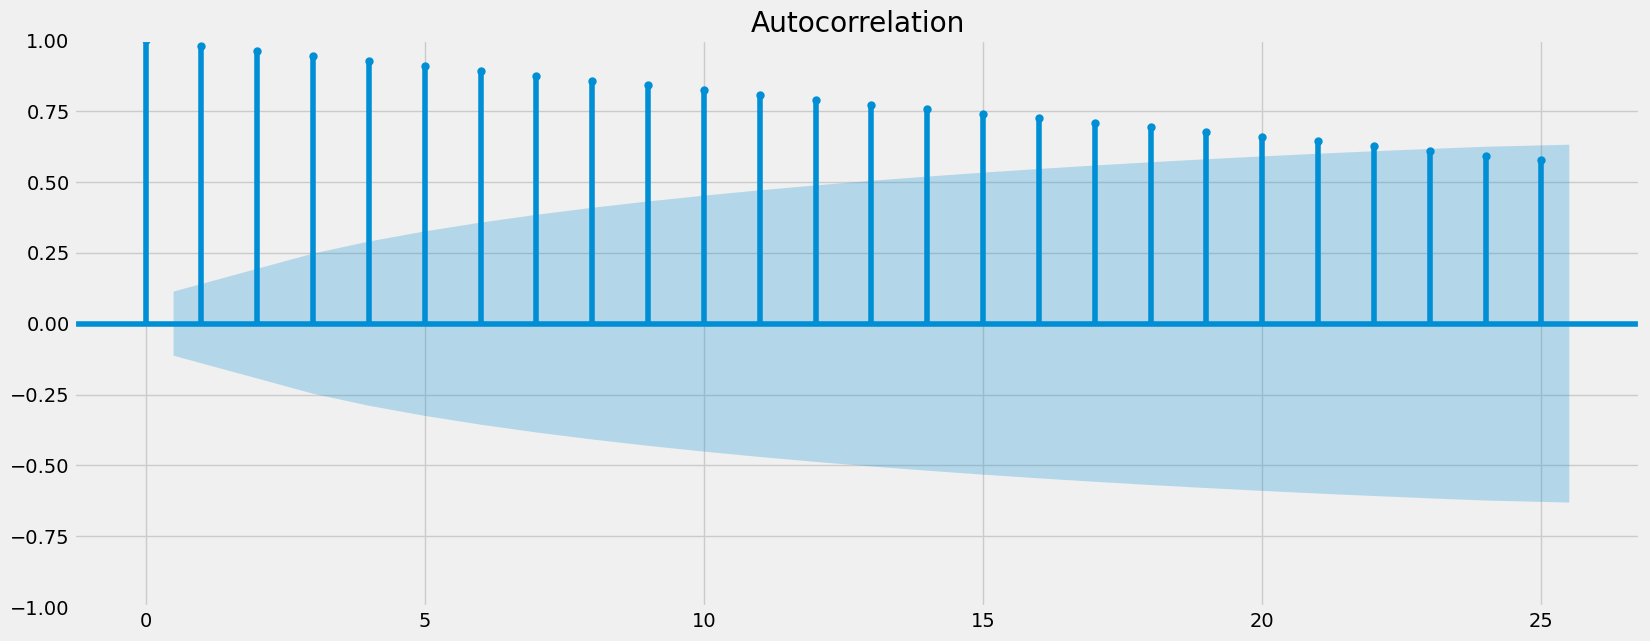

In [45]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_monthly)
plt.show()

### The Zillow Real Estate time series has most of its lags correlated with each other. This means there’s a lot of autocorrelated data and the set is likely non-stationary, which supports the result of the Dickey-Fuller test conducted earlier.

### 5. Stationarizing the Zillow Real Estate Data

In [46]:
# Differencing

data_diff = data_monthly - data_monthly.shift(1)

In [47]:
# Remove the missing values that came about as a result of the differencing

data_diff.dropna(inplace = True) 

In [48]:
data_diff.head()

,value
date,
1996-02-29,533.714286
1996-03-31,282.428571
1996-04-30,584.714286
1996-05-31,854.857143
1996-06-30,1339.285714


In [49]:
data_diff.columns

Index(['value'], dtype='object')

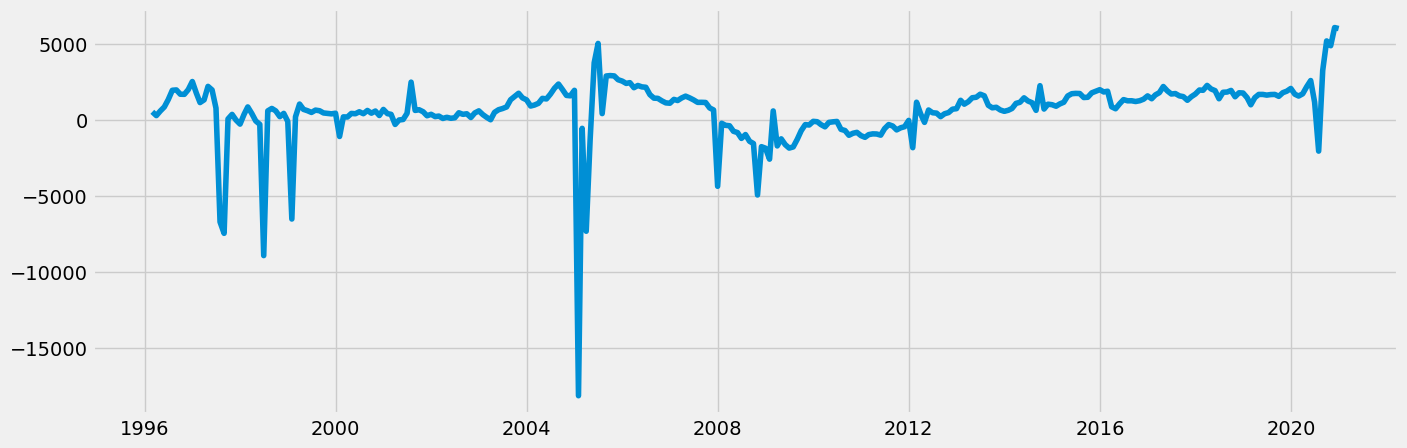

In [50]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [52]:
# Run Dickey-Fuller test for stationarity 

dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.723697
p-value                          0.070027
Number of Lags Used              9.000000
Number of Observations Used    289.000000
Critical Value (1%)             -3.453182
Critical Value (5%)             -2.871593
Critical Value (10%)            -2.572127
dtype: float64


### The test statistic is slightly bigger than the critical value at 5% significance level, but smaller than the one at 10%. The p-value is slightly bigger than 0.05. This means we can't reject the null hypothesis yet.

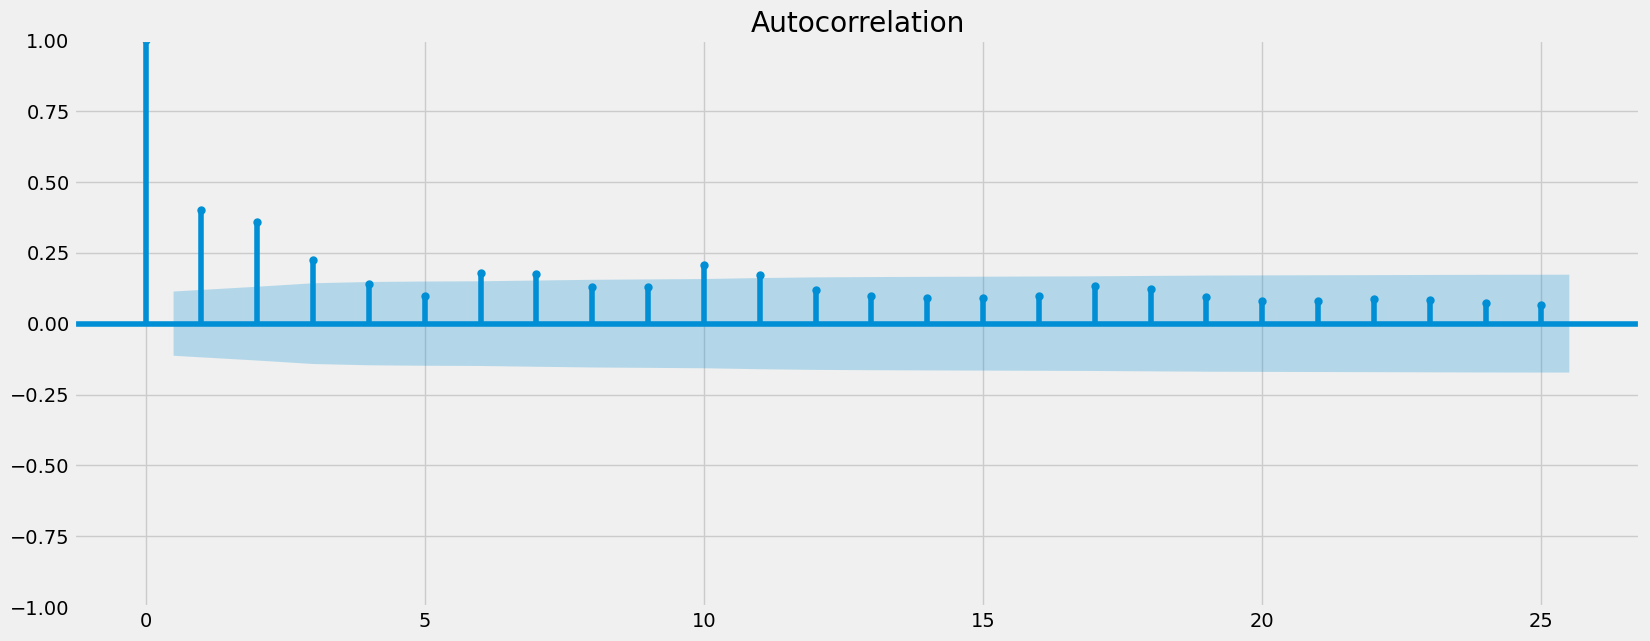

In [53]:
# Check out the autocorrelation plot

plot_acf(data_diff)
plt.show()

In [54]:
# Run a second round of differencing

data_diff_2 = data_diff - data_diff.shift(1)

In [55]:
# Remove the missing values that came about as a result of the differencing

data_diff_2.dropna(inplace = True) 

In [56]:
data_diff_2.head()

,value
date,
1996-03-31,-251.285714
1996-04-30,302.285714
1996-05-31,270.142857
1996-06-30,484.428571
1996-07-31,612.428571


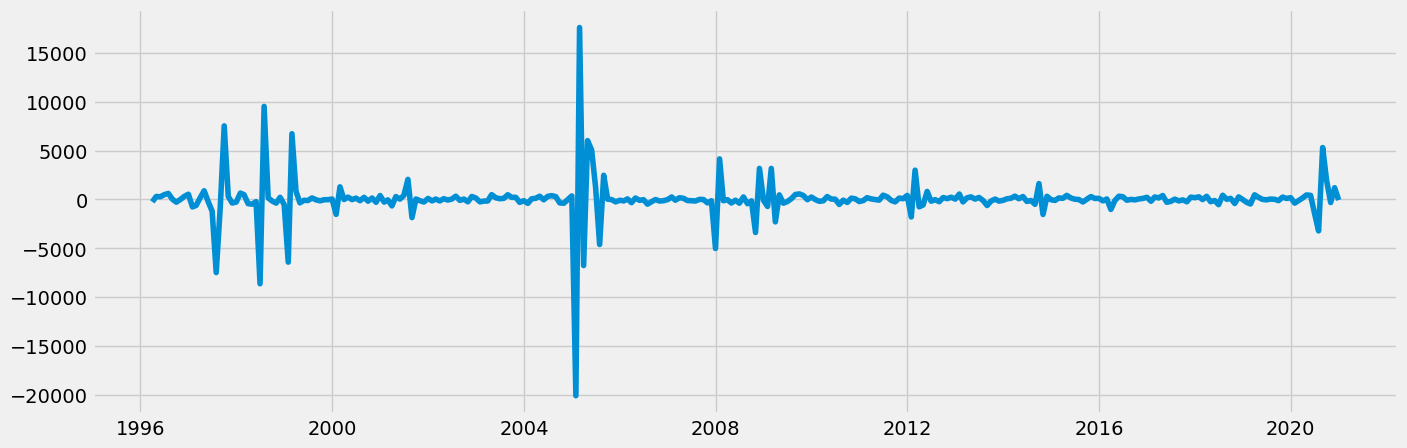

In [57]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)

In [58]:
# Run Dickey-Fuller test for stationarity 

dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                -9.032983e+00
p-value                        5.382226e-15
Number of Lags Used            9.000000e+00
Number of Observations Used    2.880000e+02
Critical Value (1%)           -3.453262e+00
Critical Value (5%)           -2.871628e+00
Critical Value (10%)          -2.572146e+00
dtype: float64


###  The test statistic is now considerably smaller than the critical value at both the five and ten percent significance levels. We also have a satisfactory p-value (p<0.05). This means we can reject the null hypothesis and consider the series stationary.

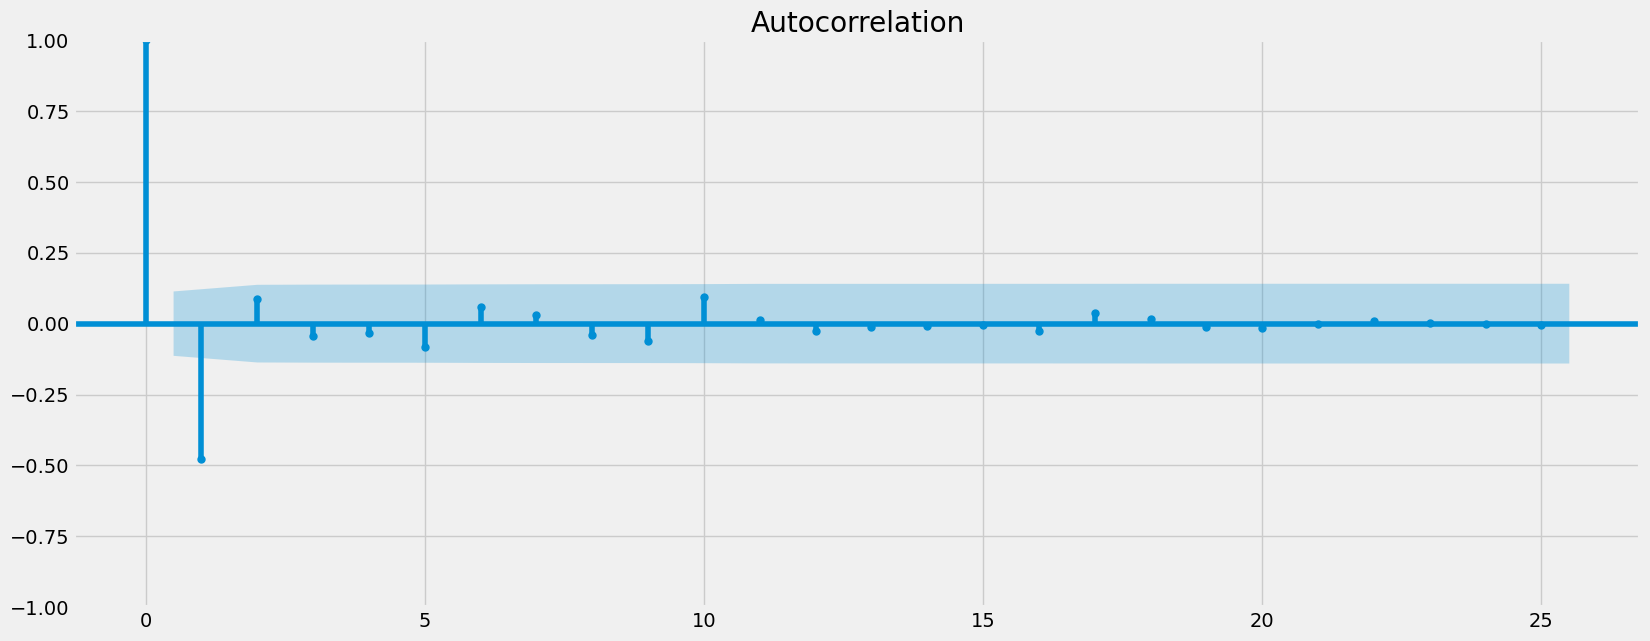

In [59]:
# Recheck the data’s autocorrelations

plot_acf(data_diff_2)
plt.show()